In [13]:
import glob # to load data
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import SGD, Adam # optimizer
from torch.nn import CrossEntropyLoss # loss function
from torch.utils.data import DataLoader # Load custom dataset
import torchvision.transforms as transforms # normalize image


import torch.nn as nn
import torch.nn.functional as F
# My Modules
# from model import Net # custom mlp net
# from dataset import Cifar10, concatenate, class_count, to_image_array # custom dataset and methods

# metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix



import pickle
import copy
from torch.utils.data import Dataset

from tqdm import tqdm


In [4]:
# hyper parameters and configurations
EPOCHS = 2
MOMENTUM = 0.9
BATCH_SIZE = 5
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device :", device)


device : cuda


In [5]:
def hist_plot(hist):
    fig = plt.figure(121, figsize=(15, 5))
    ax0 = fig.add_subplot(121)
    ax0.plot(hist[0])
    ax0.set_xlabel("Epochs")
    ax0.set_ylabel("Cross Entropy Loss")

    ax1 = fig.add_subplot(122)
    ax1.plot(hist[1])
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")

def batch_inverse_normalize(x, mean, std):
    # represent mean and std to 1, C, 1, ... tensors for broadcasting
    reshape_shape = [1, -1] + ([1] * (len(x.shape) - 2))
    mean = torch.tensor(mean, device=x.device, dtype=x.dtype).reshape(*reshape_shape)
    std = torch.tensor(std, device=x.device, dtype=x.dtype).reshape(*reshape_shape)
    return x * std + mean

def metrics(model):
    classes = testdata.classes
    y_pred, y_true = model.predict(testloader)
    precision, recall, fscore, _ = score(testdata.labels, list(y_pred))
    cm = confusion_matrix(testdata.labels, y_pred)

    # plot
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), classes)
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), classes)
    plt.show()

    # table heading
    print('{0:2s} - {1:10s} - {2:4s} - {3:4s} - {4:4s}'
    .format('Label', 'Category', 'Precision', 'Recall', 'f1-Score'))
    for label, category in enumerate(tuningdata.classes):
        print("{0:2d} - {1:10s} - {2:4f} - {3:4f} - {4:4f}"
        .format(label, category , round(precision[label], 4), round(recall[label], 3), round(fscore[label], 3)))


    print('\nConfusionMatrix\n',cm)


def unpickle(image_file):
    """
        load pickle file as a dictionary
    """

    with open(image_file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def to_image_array(image, n_channels=1024, dshape=(32, 32,3)):
    """
        convert image vector(n_channels*R, n_channels*G, n_channels*B)
        to image matrix (n_channels*(R, G, B))
    """

    r = image[0:n_channels]
    g = image[n_channels:2*n_channels]
    b = image[2*n_channels:3*n_channels]
    return np.array(list(zip(r, g, b))).reshape(*dshape)

def concatenate(datasets:list):
    """
        convert list of dataset objects to
        one dataset object
    """

    # copy one of the datasets
    result = datasets[0].copy()
    data_list = datasets[1:]

    # concat rest of dataset objects
    # with the first dataset in the list
    for data in data_list:
        result.images = np.concatenate([result.images, data.images])
        result.labels = list(np.concatenate([result.labels, data.labels]))

    return result


def class_count(dataset):
    class_count = {}
    for sample in dataset:
        label = dataset.classes[sample[1]]
        if label not in class_count:
            class_count[label] = 0
        class_count[label] += 1
    return class_count


In [6]:
class Cifar10(Dataset):
    classes = (
            'airplane',
            'automobile',
            'bird',
            'cat',
            'deer',
            'dog',
            'frog',
            'horse',
            'ship',
            'truck',
            )

    def __init__(self, root_dir, transform=None):
        data = unpickle(root_dir)
        self.labels = data[b'labels']
        self.transform = transform
        self.images = list(map(to_image_array, data[b'data']))

    def __getitem__(self, idx):
        if(torch.is_tensor(idx)):
            idx = idx.tolist()

        image = self.images[idx]
        label = self.labels[idx]
        sample = (image, label)
        if(self.transform):
            sample = (self.transform(sample[0]), sample[1])
        return sample

    def __len__(self):
        return self.labels.__len__()

    def copy(self):
        return copy.deepcopy(self)


In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # transform array to pytorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), # normlize mean for (R, G, B)
                            (0.5, 0.5, 0.5)) # normlize std for (R, G, B)
    ])

In [8]:
# Load data_batch_1
tuningdata = Cifar10("cifar-10-batches-py/data_batch_1", transform)
tuningloader = DataLoader(tuningdata, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Load test_batch
testdata = Cifar10("cifar-10-batches-py/test_batch", transform)
testloader = DataLoader(testdata, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

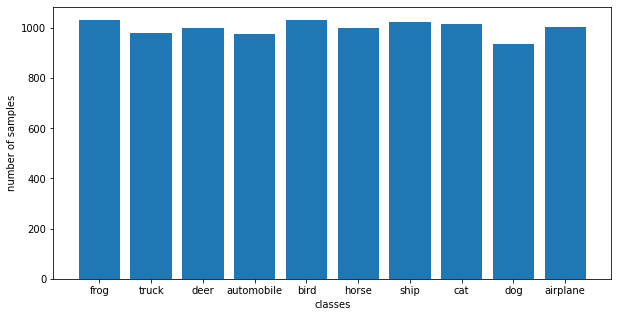

In [9]:
classes_count = class_count(tuningdata)
counts = [classes_count[key] for key in classes_count]
plt.figure(figsize=(10, 5))
plt.bar(classes_count.keys(), height=counts)
plt.xlabel('classes')
plt.ylabel('number of samples');

In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.bn1 = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(1024, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(F.relu(x))
        x = self.dropout(x)
        x = self.fc2(F.relu(self.bn1(x)))
        x = self.dropout(x)
        x = self.fc3(F.relu(x))
        x = self.sm(x)
        return x

    def train(self, trainloader, optimizer, criterion, epochs):
        # in order to return loss and accuracy
        acc_hist = []
        loss_hist = []
        for epoch in range(epochs):  # loop over the dataset multiple times
            # accuracy history
            acc = []
            total_images = 0
            total_correct = 0
            # loss history
            running_loss = []
            for data in tqdm(trainloader):
                # data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # evaluate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_images += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                running_loss.append(loss.item())


            # print loss and accuracy
            mean_loss = np.mean(running_loss)
            model_accuracy = total_correct / total_images * 100
            print('epoch: {0:<4} | loss: {1:<6} | accuracy: {2:<4}'.
            format(epoch + 1, round(mean_loss, 3), round(model_accuracy, 2)))

            loss_hist.append(mean_loss)
            acc_hist.append(model_accuracy)

        print('Finished Training')
        return [loss_hist, acc_hist]


    def score(self, testloader):
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs = self(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

    def loss(self, dataloader, criterion):
        loss = []
        with torch.no_grad():
            for data in dataloader:
                pred = self(data[0].to(device)) # predict image label
                output = torch.Tensor.cpu(pred) # bring data to the memory
                loss.append(criterion(output, data[1])) # calculate loss with predictions and true labels

        return np.mean(loss)

    def predict(self, dataloader):
        y_true = []
        outputs  = []
        with torch.no_grad():
            for data in dataloader:
                input, label = data[0].to(device), data[1].to(device)
                output = self(input)
                _ , predicted = torch.max(output.data, 1)
                outputs.append(np.array(torch.Tensor.cpu(predicted)))
                y_true.append(np.array(torch.Tensor.cpu(label)))

        return np.ravel(outputs), y_true


<h1>
    Tuning Model
</h1>
<h3>
    train using batch number 1 include 10,000 image data with labels
</h3>

In [16]:
# create and config tuning model

tuning_model = Net()
criterion = CrossEntropyLoss()
optimizer = SGD(tuning_model.parameters(),
                lr=LEARNING_RATE,
                momentum=0.9)
tuning_model.to(device)

# list of loss and accuracy
hist = [[], []]

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 1    | loss: 2.263  | accuracy: 19.05


100%|██████████| 2000/2000 [00:11<00:00, 167.85it/s]


epoch: 2    | loss: 2.212  | accuracy: 24.31
Finished Training


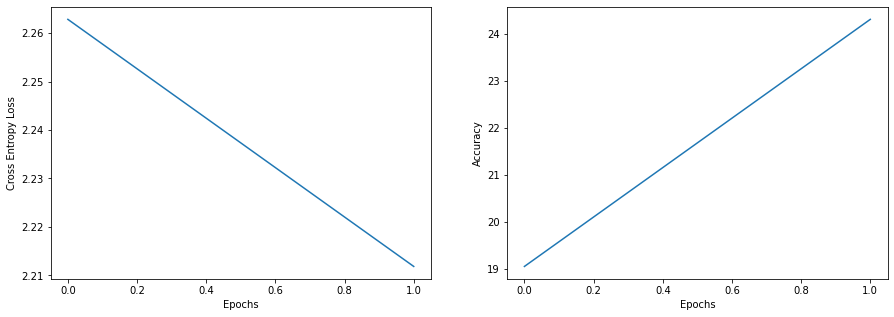

In [17]:
res = []
res += tuning_model.train(tuningloader, optimizer, criterion, epochs=EPOCHS)

# save older results
hist[0] += res[0]
hist[1] += res[1]
hist_plot(hist)

/home/mohammad/.local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1134: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


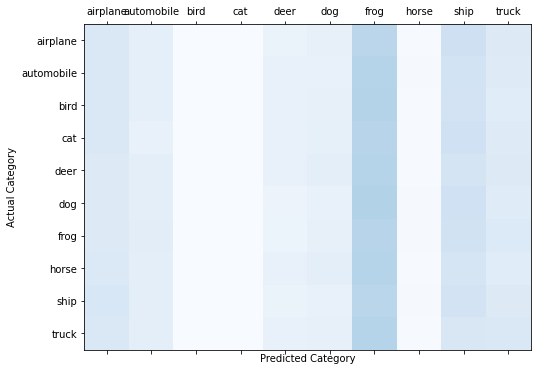

Label - Category   - Precision - Recall - f1-Score
 0 - airplane   - 0.100300 - 0.141000 - 0.117000
 1 - automobile - 0.100000 - 0.093000 - 0.096000
 2 - bird       - 0.000000 - 0.000000 - 0.000000
 3 - cat        - 0.000000 - 0.000000 - 0.000000
 4 - deer       - 0.105100 - 0.072000 - 0.085000
 5 - dog        - 0.091500 - 0.075000 - 0.082000
 6 - frog       - 0.099300 - 0.296000 - 0.149000
 7 - horse      - 0.104500 - 0.007000 - 0.013000
 8 - ship       - 0.098800 - 0.183000 - 0.128000
 9 - truck      - 0.112400 - 0.141000 - 0.125000

ConfusionMatrix
 [[141  88   0   0  66  81 282   5 208 129]
 [147  93   0   0  71  75 297   8 187 122]
 [146  89   0   1  76  81 305   5 181 116]
 [143  75   0   0  73  83 295   6 202 123]
 [127  96   0   2  72  94 301   7 174 127]
 [132  96   0   0  56  75 311   8 203 119]
 [130 103   0   1  53  80 296   8 193 136]
 [138  96   0   0  76  95 302   7 171 115]
 [155 100   0   0  64  76 287   8 183 127]
 [147  94   0   0  78  80 304   5 151 141]]


In [18]:
metrics(tuning_model)

In [19]:
# concatenate all batch data
batches_list = []
for batch_data in glob.glob("cifar-10-batches-py/data_batch_*"):
    batches_list.append(Cifar10(batch_data, transform))
batches_list

traindata = concatenate(batches_list)
trainloader = DataLoader(traindata, batch_size=10, shuffle=True, num_workers=2)


<h1>
    Main Model
</h1>
<h3>
    train using All data include 50,000 image data with labels
</h3>

In [20]:
model = Net()
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
model.to(device)
model_hist = [[], []]

  0%|          | 0/5000 [00:00<?, ?it/s]

epoch: 1    | loss: 2.207  | accuracy: 25.05


100%|██████████| 5000/5000 [00:28<00:00, 175.12it/s]


epoch: 2    | loss: 2.141  | accuracy: 31.84
Finished Training


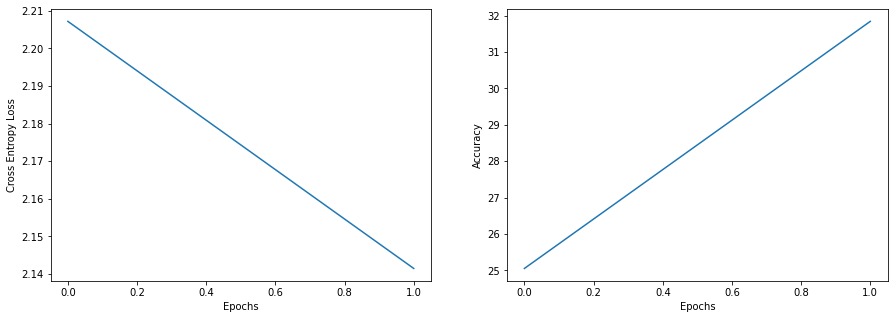

In [21]:
res = []
res += model.train(trainloader, optimizer, criterion, epochs=EPOCHS)

# save older results
model_hist[0] += res[0]
model_hist[1] += res[1]
hist_plot(model_hist)

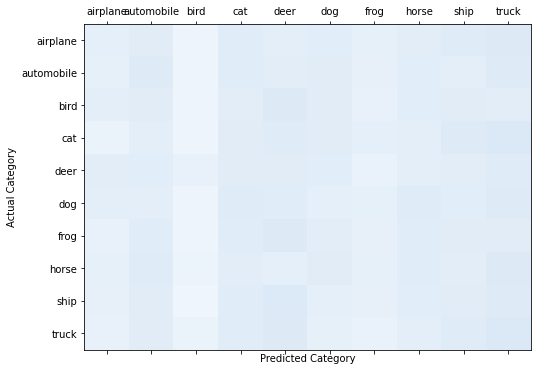

Label - Category   - Precision - Recall - f1-Score
 0 - airplane   - 0.106600 - 0.091000 - 0.098000
 1 - automobile - 0.111600 - 0.124000 - 0.117000
 2 - bird       - 0.090900 - 0.048000 - 0.063000
 3 - cat        - 0.099400 - 0.112000 - 0.105000
 4 - deer       - 0.096400 - 0.111000 - 0.103000
 5 - dog        - 0.089300 - 0.092000 - 0.091000
 6 - frog       - 0.101100 - 0.080000 - 0.089000
 7 - horse      - 0.109200 - 0.116000 - 0.113000
 8 - ship       - 0.101300 - 0.112000 - 0.106000
 9 - truck      - 0.110600 - 0.137000 - 0.122000

ConfusionMatrix
 [[ 91 111  47 115  94 106  85 102 118 131]
 [ 83 124  48 115 104 113  82 108  99 124]
 [ 97 113  48 105 131 113  73 106 110 104]
 [ 66 101  50 112 118 110  86  96 124 137]
 [104 109  71 112 111 108  68  95 104 118]
 [ 97  96  47 121 114  92  83 119 108 123]
 [ 74 115  50 115 127 102  80 114 111 112]
 [ 84 120  59 102  93 112  83 116 102 129]
 [ 80 111  45 115 135  90  82 106 112 124]
 [ 78 111  63 115 125  84  69 100 118 137]]


In [ ]:
metrics(model)

In [ ]:
model.score(testloader)

Accuracy of the network on the 10000 test images: 38 %


In [ ]:
current_path = !pwd
filename = "/cifar10_model"
current_path[0] += filename
current_path[0]

'/home/mohammad/Desktop/Desktop/aimedic/project2_MohammadRezaei/cifar10_model'

In [ ]:
torch.save(model.state_dict(), current_path[0])